In [5]:
# import packages
import numpy as np
import pandas as pd
import math
import itertools

#matplotlib libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors
import seaborn as sns

#date libraries
from dateutil import parser
from datetime import datetime, timedelta, date
import holidays

#prophet library
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf

## Data Preparation for Prophet models ADD PROPHET EQUATION

2. Data Preparation:

Prophet offers distinct advantages over ARIMA models in time series forecasting. Notably, deals much better with handling missing data, accommodating holidays and special events seamlessly, and providing an intuitive parameter tuning process. Prophet is an Additive Regressive Model, its architecture employs a piecewise linear function for trend modeling with automatic changepoint detection, Fourier series for seasonality representation, and explicit incorporation of holidays. Key parameters like changepoint_prior_scale and seasonality_prior_scale allow users to control the model's flexibility and strength of seasonality.

Equation:
**y(t) = g(t) + h(t) + s(t) + et **

Where:
- y(t): Additive Regressive Model
- g(t): Trend Factor
- h(t): Holiday component
- s(t): Seasonality Component
- et: Error term

The dataset preparation for the Prophet (univariate) model closely mirrors the procedures I've employed for ARIMA models. The initial step involved grouping the data by date, ensuring a chronological order. Subsequently, I've scaled the dataset accordingly.


The primary data transformation necessary for compatibility with the Prophet (univariate) model involved the formatting of the input features. Specifically, the 'Date' column and the variable to be predicted need to be included in the dataset and named 'ds' and 'y', respectively. This specific naming convention is imperative, as the Prophet model expects data to adhere to these precise column names. By conforming to this requirement, I ensured that the model correctly interprets the time information in the 'ds' column and the corresponding target variable in the 'y' column.

In [ ]:
import warnings

# Suppress specific warning types
warnings.filterwarnings("ignore")

pred_var = 'Additional_Doses_Vax_Pct'

df = pd.read_csv('df_post_eda.csv')

# group data by Date
df['Date'] = pd.to_datetime(df['Date'])
df = df.groupby('Date')[pred_var].mean()

#subset data to be only dates and predicting variable values
data = pd.DataFrame(df)

# resambpling to weekly datetime to prevent convergence warnings
data_w = data.resample('W').sum()

#scaling data
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
data = pd.DataFrame(min_max_scaler.fit_transform(data_w), columns=data.columns, index=data_w.index)
data = data.reset_index()

## Developemnt

In [7]:
# Split data into test and train

split_date = int(len(data) * 0.8)
data = data.sort_values(by ='Date',ascending=True)

# Split the data
train_data = data.iloc[:split_date]
test_data = data.iloc[split_date:]

# indentify forecast date
forecast_start_dt = date(2023,1,29) #data set ends of (2023,1,29)
forecast_start_date = (forecast_start_dt).strftime("%Y-%m-%d")
#print(forecast_start_date)
prediction_days = 16

# Initial Prophet Model

- Fitted initial univariate prophet model with default setting to inspect the rmse.

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/_gb9cd8b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/1sx2ge0l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77517', 'data', 'file=/tmp/tmprxx_h9l3/_gb9cd8b.json', 'init=/tmp/tmprxx_h9l3/1sx2ge0l.json', 'output', 'file=/tmp/tmprxx_h9l3/prophet_model0gnponea/prophet_model-20231125191528.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:15:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:15:28 - cmdstanpy - INFO - Chai

Train RMSE: 0.0030205145886325166
Test RMSE: 0.02683607297706949


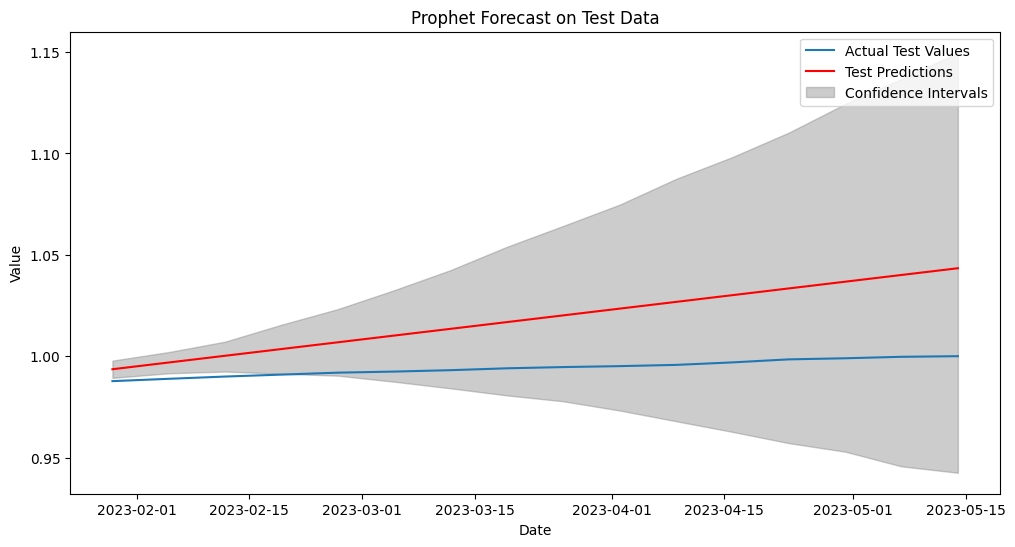

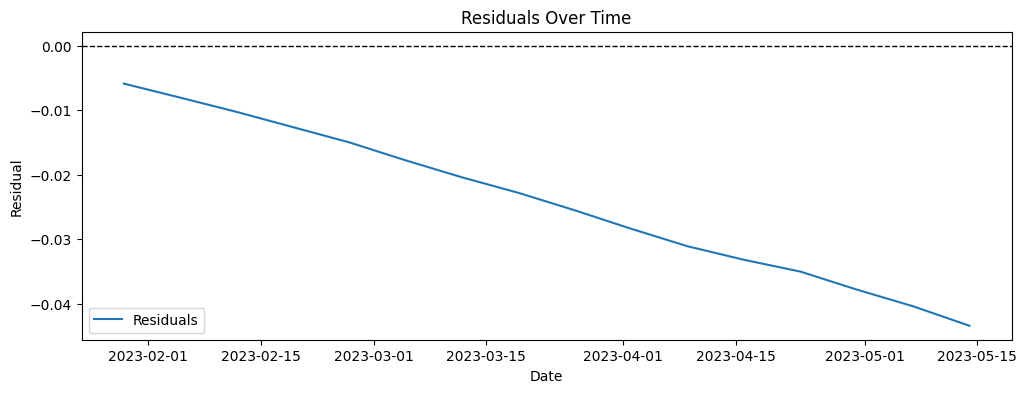

<Figure size 1000x800 with 0 Axes>

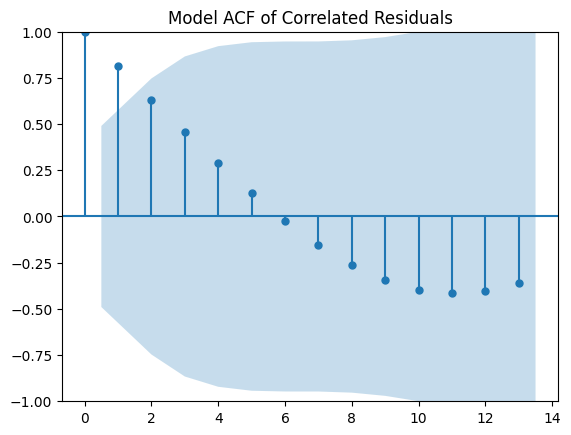

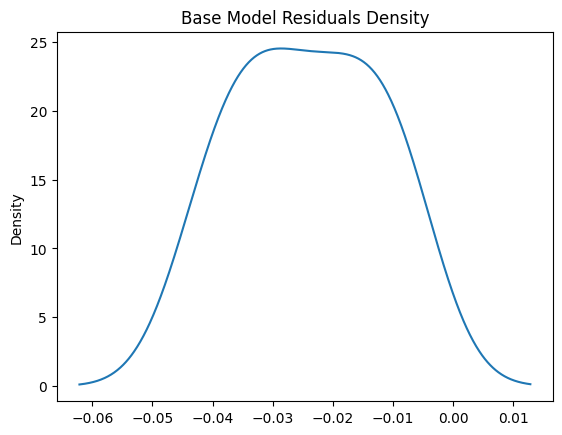

In [9]:
def train_prophet_model(train_data):
    m = Prophet()
    m.fit(train_data)
    return m

def make_predictions(model, future_data):
    forecast = model.predict(future_data)
    return forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

def calculate_rmse(true_values, predicted_values):
    return np.sqrt(mean_squared_error(true_values, predicted_values))

def plot_forecast(test_data, predicted_data):
    plt.figure(figsize=(12, 6))
    plt.plot(test_data['ds'], test_data['y'], label='Actual Test Values')
    plt.plot(predicted_data['ds'], predicted_data['yhat'], label='Test Predictions', color='red')
    plt.fill_between(predicted_data['ds'], predicted_data['yhat_lower'], predicted_data['yhat_upper'], color='gray', alpha=0.4, label='Confidence Intervals')
    plt.title('Prophet Forecast on Test Data')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

def plot_residuals(predicted_data):
    plt.figure(figsize=(12, 4))
    plt.plot(predicted_data['ds'], predicted_data['residuals'], label='Residuals')
    plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
    plt.title('Residuals Over Time')
    plt.xlabel('Date')
    plt.ylabel('Residual')
    plt.legend()
    plt.show()

def plot_residual_acf(predicted_data):
    plt.figure(figsize=(10, 8))
    acf_original = plot_acf(predicted_data['residuals'])
    plt.title("Model ACF of Correlated Residuals")
    plt.show()

def plot_residual_density(predicted_data):
    predicted_data['residuals'].plot(kind='kde', title='Base Model Residuals Density')
    plt.show()

# Assuming 'Date' and 'y' are your date and target columns
df_copy = data.copy()
df_copy = df_copy.rename(columns={'Date': 'ds', pred_var: 'y'})
df_copy[['y']] = df_copy[['y']].apply(pd.to_numeric)

df_copy['ds'] = pd.to_datetime(df_copy['ds'])

# Split the data into training and test sets
train_set = df_copy[df_copy['ds'] < forecast_start_date]
test_set = df_copy[df_copy['ds'] >= forecast_start_date]

# Train the model
model = train_prophet_model(train_set)

# Make future dataframe for predictions
future = model.make_future_dataframe(periods=len(test_set), freq='W')
forecast = make_predictions(model, future)

# Storing values for visualization and residuals
predicted_df = pd.merge(test_set[['ds', 'y']], forecast, on='ds')
predicted_df['residuals'] = predicted_df['y'] - predicted_df['yhat']

# Calculate Train RMSE
rmse_train = calculate_rmse(train_set['y'], model.predict(train_set)['yhat'])
print(f"Train RMSE: {rmse_train}")

# Calculate Test RMSE
rmse_test = calculate_rmse(predicted_df['y'], predicted_df['yhat'])
print(f"Test RMSE: {rmse_test}")

# Plot forecast
plot_forecast(test_set, predicted_df)

# Plot residuals
plot_residuals(predicted_df)

# Plot residual ACF
plot_residual_acf(predicted_df)

# Plot residual density
plot_residual_density(predicted_df)


The baseline Prophet model, trained with default parameters, exhibits a remarkably low Train RMSE of 0.003, indicating a close fit to the training data. However, the Test RMSE of 0.02, while relatively low, suggests a noticeable difference in performance between the training and test sets, hinting at potential overfitting or a challenge in generalization to unseen data. The plot of actual vs. predicted test values reveals a consistent overestimation trend by the model, indicating a systematic bias. Notably, the widening confidence intervals over time signal a growing uncertainty in long-term predictions. The residuals analysis unveils a negative slope in both the residuals over time plot and the ACF of correlated residuals, suggesting a tendency to overestimate and a possible oversight in capturing underlying patterns. The residuals density plot, not centered around zero, further supports the notion of bias.

cross validation with Prophet

My next step was to implement cross-validation,a valuable tool to address overfitting and provide a more comprehensive understanding of how a model performs with unseen data. In pursuit of optimal model performance, I executed a parameter grid search, and the corresponding code is available in the appendix. Guided by the outcomes of the initial grid search, I configured my cross-validation strategy to entail training the model on the first week, generating predictions for the subsequent week, and iteratively repeating this cycle with a 2-week interval between each training and evaluation period. This configuration proves apt for evaluating the model's capacity to generalize to short-term predictions, specifically emphasizing a 1-week forecasting horizon. This choice aligns with the nature of the test data set, which spans only 16 weeks, thereby qualifying as a short-term. Furthermore, short-term forecasting proves advantageous for non-stationary data, effectively capturing volatile trends within the dataset.

In [ ]:
## TUNING for cross validation params iterate through entire grid

from sklearn.model_selection import ParameterSampler
from sklearn.model_selection import ParameterGrid

param_grid = {
    'initial': list(range(7, 175, 7)),
    'period': [7, 14, 21] ,
    'horizon': [7, 14, 21]
}

all_params = list(ParameterGrid(param_grid))

best_rmse = float('inf')
best_params = None

for params in all_params:
    model = Prophet().fit(train_set)
    horizon = f'{params["horizon"]} days'
    initial = f'{params["initial"]} days'
    period = f'{params["period"]} days'

    df_cv = cross_validation(model, horizon=horizon, initial=initial, period=period)

    metrics = performance_metrics(df_cv)
    rmse = metrics['rmse'].mean()

    if rmse < best_rmse:
        best_rmse = rmse
        best_params = params

print("Best Parameters:", best_params)
print("Best RMSE:", best_rmse)

Model with Cross Validation

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/onbutlah.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/rbhxjy8y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40805', 'data', 'file=/tmp/tmprxx_h9l3/onbutlah.json', 'init=/tmp/tmprxx_h9l3/rbhxjy8y.json', 'output', 'file=/tmp/tmprxx_h9l3/prophet_modelxa55k38x/prophet_model-20231125193829.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:38:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:38:29 - cmdstanpy - INFO - Chai

  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/lylfm27p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/31bj9859.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1462', 'data', 'file=/tmp/tmprxx_h9l3/lylfm27p.json', 'init=/tmp/tmprxx_h9l3/31bj9859.json', 'output', 'file=/tmp/tmprxx_h9l3/prophet_modelemyzhsek/prophet_model-20231125193829.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:38:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:38:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/iciyb415.json
DEBUG:cmdstanpy:input tempfile:

  horizon       mse     rmse       mae      mape    mdape     smape  coverage
0  7 days  0.011075  0.10524  0.071659  0.085531  0.02675  0.078545  0.290323
Train RMSE: 0.0030205145886325166
Test RMSE: 0.02683607297706949


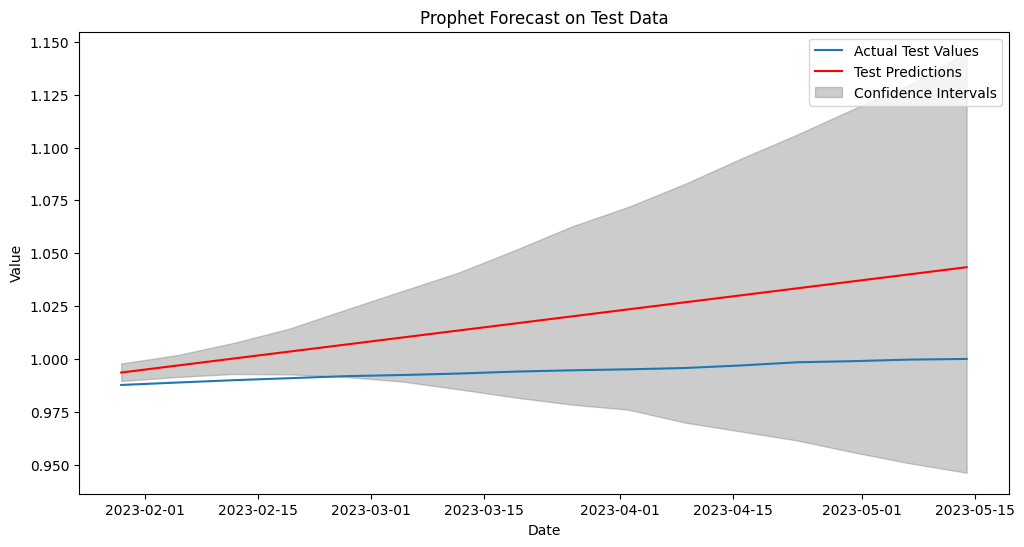

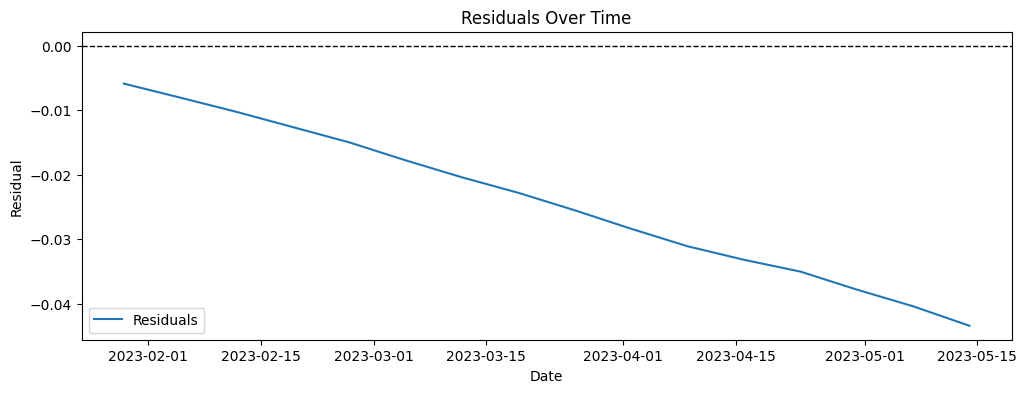

<Figure size 1000x800 with 0 Axes>

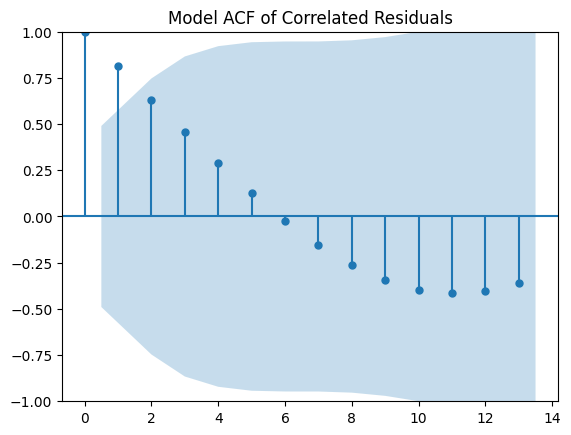

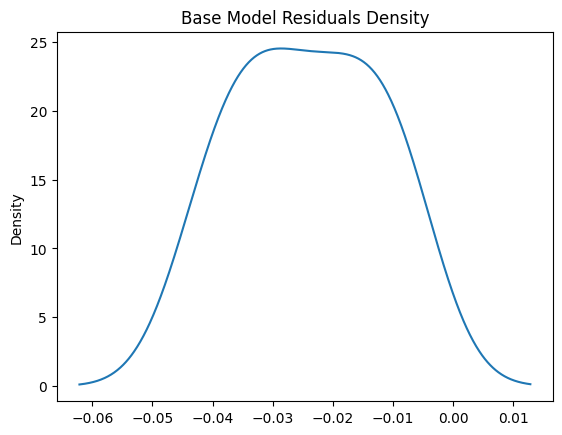

In [11]:
def train_prophet_model(train_data):
    model = Prophet()
    model.fit(train_data)
    return model

def perform_cross_validation(model, initial, period, horizon):
    return cross_validation(model, initial=initial, period=period, horizon=horizon)

def calculate_rmse(true_values, predicted_values):
    return np.sqrt(mean_squared_error(true_values, predicted_values))

def plot_forecast_and_intervals(predicted_df):
    plt.figure(figsize=(12, 6))
    plt.plot(predicted_df.ds, predicted_df.ytrue, label='Actual Test Values')
    plt.plot(predicted_df.ds, predicted_df.yhat, label='Test Predictions', color='red')
    plt.fill_between(predicted_df.ds, predicted_df.yhat_lower, predicted_df.yhat_upper, color='gray', alpha=0.4, label='Confidence Intervals')
    plt.title('Prophet Forecast on Test Data')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

def plot_residuals(predicted_df):
    plt.figure(figsize=(12, 4))
    plt.plot(predicted_df.ds, predicted_df.residuals, label='Residuals')
    plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
    plt.title('Residuals Over Time')
    plt.xlabel('Date')
    plt.ylabel('Residual')
    plt.legend()
    plt.show()

def plot_residual_acf(predicted_df):
    plt.figure(figsize=(10, 8))
    acf_original = plot_acf(predicted_df.residuals)
    plt.title("Model ACF of Correlated Residuals")
    plt.show()

def plot_residual_density(predicted_df):
    predicted_df.residuals.plot(kind='kde', title='Base Model Residuals Density')
    plt.show()

# Assuming df is your DataFrame with columns 'ds' and 'y'
df = data.copy()
df.columns = ['ds', 'ytrue']

# Train the initial model
m = train_prophet_model(train_set)

# Perform cross-validation
df_cv = perform_cross_validation(m, initial='1 W', period='2 W', horizon='1 W')

# Compute performance metrics
df_metrics = performance_metrics(df_cv)
#print(df_metrics)

# Make future dataframe for predictions
future = m.make_future_dataframe(periods=prediction_days, freq='W')
fcst_prophet_train = m.predict(future)

# Filter to include only forecasted data
predicted_df = fcst_prophet_train[fcst_prophet_train['ds'] >= forecast_start_date][['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Store values for visualization and residuals
df_copy = test_data.copy()
df_copy.columns = ['ds', 'ytrue']
predicted_df = pd.merge(df_copy, predicted_df, on='ds')

# Calculate Train RMSE
y_train_true = train_set['y']
y_train_pred = fcst_prophet_train['yhat'][:len(train_set)]
rmse_train = calculate_rmse(y_train_true, y_train_pred)
print(f"Train RMSE: {rmse_train}")

# Calculate Test RMSE
rmse_test = calculate_rmse(predicted_df['ytrue'], predicted_df['yhat'])
print(f"Test RMSE: {rmse_test}")

# Add residuals to the predicted_df
predicted_df['residuals'] = predicted_df.ytrue - predicted_df.yhat

# Plot the forecast and intervals
plot_forecast_and_intervals(predicted_df)

# Plot residuals over time
plot_residuals(predicted_df)

# Plot residual ACF
plot_residual_acf(predicted_df)

# Plot residual density
plot_residual_density(predicted_df)


In [ ]:
# most likely not include

## Hyperparameter Tunning

Tunning Process

In the tuning process, I learned about Prophet parameters and realzied they are primarily related to seasonal trends, which I suspected might not strongly influence my data due to its cumulative nature. I conducted a coarse grid search which focused on exploring values for seasonality_prior_scale, holidays_prior_scale, changepoint_prior_scale, and the number of changepoints. The results indicated small values for both seasonality and holidays, aligning with expectations that these factors have minimal impact on the data, especially considering the weekly aggregation. Following this, I refined the parameter range and performed a finer grid search. Notably, I extended the tuning to include the number of changepoints, a factor I believed could significantly affect the model. Changepoints denote abrupt shifts in the time series trajectory, and while the data exhibits a consistent upward trend, small changes were observed to have a notable impact, particularly in early time ranges, as evident from discrepancies in ARIMA model fits.




1. **`seasonality_prior_scale` (float):**
   - Controls the strength of the seasonality model. Higher values allow the model to fit the training data more closely but may lead to overfitting.

2. **`holidays_prior_scale` (float):**
   - Controls the strength of the holiday effects. Similar to `seasonality_prior_scale`, it adjusts the impact of holidays on the model.

3. **`changepoint_prior_scale` (float):**
   - Controls the flexibility of the trend. A higher value makes the trend more flexible, capturing more short-term fluctuations, but it can lead to overfitting.

5. **`n_changepoints` (int):**
   - Number of potential changepoints to include. The default is 25, but you can adjust this to capture more or fewer potential changepoints.


Coarse Grid Search

In [12]:
# Assuming df is your DataFrame with columns 'ds' and 'ytrue'
df = data.copy()
df.columns = ['ds', 'y']

# Split the data into training and test sets
train_size = int(0.8 * len(df))
train_set = df[:train_size]
test_set = df[train_size:]

# Specify the number of days in a week for the weekly seasonality
days_in_week = 7

# Define hyperparameter values to try
seasonality_prior_scale_values = [0.01, 0.1, 0.5]
holidays_prior_scale_values = [0.01, 0.1, 0.5]
changepoint_prior_scale_values = [0.01, 0.1, 0.5]
n_changepoints_values = [10, 20, 30]  # Adjust the range as needed

best_params = None
best_rmse = float('inf')

# Iterate over hyperparameter values
for seasonality_prior_scale in seasonality_prior_scale_values:
    for holidays_prior_scale in holidays_prior_scale_values:
        for changepoint_prior_scale in changepoint_prior_scale_values:
            for n_changepoints in n_changepoints_values:
                # Initialize the Prophet model with hyperparameters
                m = Prophet(
                    weekly_seasonality=True,
                    yearly_seasonality=False,
                    seasonality_prior_scale=seasonality_prior_scale,
                    holidays_prior_scale=holidays_prior_scale,
                    changepoint_prior_scale=changepoint_prior_scale,
                    n_changepoints=n_changepoints
                )

                # Fit the model on the training dataset
                m.fit(train_set)

                # Perform cross-validation on the training data
                df_cv = cross_validation(m, initial='1 W', period='2 W', horizon='1 W')

                # Compute performance metrics on the training data
                df_metrics = performance_metrics(df_cv)

                # Track the best hyperparameters based on training data performance
                avg_rmse = df_metrics['rmse'].mean()
                if avg_rmse < best_rmse:
                    best_rmse = avg_rmse
                    best_params = {
                        'seasonality_prior_scale': seasonality_prior_scale,
                        'holidays_prior_scale': holidays_prior_scale,
                        'changepoint_prior_scale': changepoint_prior_scale,
                        'n_changepoints': n_changepoints
                    }

# Display the best hyperparameters based on training data
print("Best Hyperparameters (Training Data):", best_params)


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/ehb27kqk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/2f9yd9bv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51050', 'data', 'file=/tmp/tmprxx_h9l3/ehb27kqk.json', 'init=/tmp/tmprxx_h9l3/2f9yd9bv.json', 'output', 'file=/tmp/tmprxx_h9l3/prophet_modell1ejor6y/prophet_model-20231125194827.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:48:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:48:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 31 forecasts with cutoffs between 2021-11-21 00:00:00 and 2023-01-15 00:00:00


  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/fk6t5ukd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/agi4zj85.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80197', 'data', 'file=/tmp/tmprxx_h9l3/fk6t5ukd.json', 'init=/tmp/tmprxx_h9l3/agi4zj85.json', 'output', 'file=/tmp/tmprxx_h9l3/prophet_modelp9rxf6vk/prophet_model-20231125194827.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:48:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:48:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/pyezc1fx.json
DEBUG:cmdstanpy:input tempfile

  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/bf3_6o4s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/lkyqbpf9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51149', 'data', 'file=/tmp/tmprxx_h9l3/bf3_6o4s.json', 'init=/tmp/tmprxx_h9l3/lkyqbpf9.json', 'output', 'file=/tmp/tmprxx_h9l3/prophet_modelmq84re02/prophet_model-20231125194835.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:48:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:48:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/g_td0eno.json
DEBUG:cmdstanpy:input tempfile

  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/4y892x9q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/nvin76us.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60722', 'data', 'file=/tmp/tmprxx_h9l3/4y892x9q.json', 'init=/tmp/tmprxx_h9l3/nvin76us.json', 'output', 'file=/tmp/tmprxx_h9l3/prophet_modelvczrzfym/prophet_model-20231125194841.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:48:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:48:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/n8wgptvn.json
DEBUG:cmdstanpy:input tempfile

  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/v2dzna8j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/1n1_9n83.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62372', 'data', 'file=/tmp/tmprxx_h9l3/v2dzna8j.json', 'init=/tmp/tmprxx_h9l3/1n1_9n83.json', 'output', 'file=/tmp/tmprxx_h9l3/prophet_model06rxf7so/prophet_model-20231125194851.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:48:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:48:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/87ofthfx.json
DEBUG:cmdstanpy:input tempfile

  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/bh4hapf3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/6_r16t9l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80892', 'data', 'file=/tmp/tmprxx_h9l3/bh4hapf3.json', 'init=/tmp/tmprxx_h9l3/6_r16t9l.json', 'output', 'file=/tmp/tmprxx_h9l3/prophet_model18la2yoz/prophet_model-20231125194901.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:49:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:49:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/l33rjw2k.json
DEBUG:cmdstanpy:input tempfile

  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/39lhskbe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/0nq3pilg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39349', 'data', 'file=/tmp/tmprxx_h9l3/39lhskbe.json', 'init=/tmp/tmprxx_h9l3/0nq3pilg.json', 'output', 'file=/tmp/tmprxx_h9l3/prophet_modello6weqck/prophet_model-20231125194918.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:49:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:49:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/sp8y3avs.json
DEBUG:cmdstanpy:input tempfile

  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/6vhgjold.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/llc5pmop.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59123', 'data', 'file=/tmp/tmprxx_h9l3/6vhgjold.json', 'init=/tmp/tmprxx_h9l3/llc5pmop.json', 'output', 'file=/tmp/tmprxx_h9l3/prophet_modely60nt_k5/prophet_model-20231125194941.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:49:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:49:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/onzd8cpd.json
DEBUG:cmdstanpy:input tempfile

  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/0j5nvhfu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/7071znj7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47613', 'data', 'file=/tmp/tmprxx_h9l3/0j5nvhfu.json', 'init=/tmp/tmprxx_h9l3/7071znj7.json', 'output', 'file=/tmp/tmprxx_h9l3/prophet_modeluspipous/prophet_model-20231125194953.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:49:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:49:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/3ds3z8fl.json
DEBUG:cmdstanpy:input tempfile

  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/n3fw5_nt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/wzyg24sc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35690', 'data', 'file=/tmp/tmprxx_h9l3/n3fw5_nt.json', 'init=/tmp/tmprxx_h9l3/wzyg24sc.json', 'output', 'file=/tmp/tmprxx_h9l3/prophet_modeli25louvy/prophet_model-20231125195007.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:50:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:50:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/9zmt0wch.json
DEBUG:cmdstanpy:input tempfile

  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/bvl0vntr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/wjb7xcba.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5078', 'data', 'file=/tmp/tmprxx_h9l3/bvl0vntr.json', 'init=/tmp/tmprxx_h9l3/wjb7xcba.json', 'output', 'file=/tmp/tmprxx_h9l3/prophet_modelczjk5hms/prophet_model-20231125195030.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:50:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:50:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/v0zuny6m.json
DEBUG:cmdstanpy:input tempfile:

  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/uks7remn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/f2yd0qrq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73679', 'data', 'file=/tmp/tmprxx_h9l3/uks7remn.json', 'init=/tmp/tmprxx_h9l3/f2yd0qrq.json', 'output', 'file=/tmp/tmprxx_h9l3/prophet_model08upmk0g/prophet_model-20231125195037.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:50:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:50:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/tebp8_36.json
DEBUG:cmdstanpy:input tempfile

  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/8ufn6dnq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/iij85fuy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30696', 'data', 'file=/tmp/tmprxx_h9l3/8ufn6dnq.json', 'init=/tmp/tmprxx_h9l3/iij85fuy.json', 'output', 'file=/tmp/tmprxx_h9l3/prophet_modell0xuamcl/prophet_model-20231125195046.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:50:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:50:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/3zv56psh.json
DEBUG:cmdstanpy:input tempfile

  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/pzz6q_05.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/z_d15fma.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83704', 'data', 'file=/tmp/tmprxx_h9l3/pzz6q_05.json', 'init=/tmp/tmprxx_h9l3/z_d15fma.json', 'output', 'file=/tmp/tmprxx_h9l3/prophet_modelpyq73uww/prophet_model-20231125195054.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:50:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:50:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/zs7kf30d.json
DEBUG:cmdstanpy:input tempfile

  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/itr52yit.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/91500m58.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38485', 'data', 'file=/tmp/tmprxx_h9l3/itr52yit.json', 'init=/tmp/tmprxx_h9l3/91500m58.json', 'output', 'file=/tmp/tmprxx_h9l3/prophet_modelyxt4rfbx/prophet_model-20231125195107.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:51:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:51:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/48djd5gj.json
DEBUG:cmdstanpy:input tempfile

  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/4_h6emuk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/udlv8de1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32742', 'data', 'file=/tmp/tmprxx_h9l3/4_h6emuk.json', 'init=/tmp/tmprxx_h9l3/udlv8de1.json', 'output', 'file=/tmp/tmprxx_h9l3/prophet_modelowpr3_5c/prophet_model-20231125195123.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:51:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:51:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/ng7kf1dc.json
DEBUG:cmdstanpy:input tempfile

  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/c4rubxey.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/zh7_068m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46343', 'data', 'file=/tmp/tmprxx_h9l3/c4rubxey.json', 'init=/tmp/tmprxx_h9l3/zh7_068m.json', 'output', 'file=/tmp/tmprxx_h9l3/prophet_modelkx4ywwkp/prophet_model-20231125195141.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:51:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:51:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/npy2a1lg.json
DEBUG:cmdstanpy:input tempfile

  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/b0b_6pfv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/2dck07lc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56869', 'data', 'file=/tmp/tmprxx_h9l3/b0b_6pfv.json', 'init=/tmp/tmprxx_h9l3/2dck07lc.json', 'output', 'file=/tmp/tmprxx_h9l3/prophet_model3x5xfjoe/prophet_model-20231125195155.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:51:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:51:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/72u_zjyg.json
DEBUG:cmdstanpy:input tempfile

  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/swbpuf6_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/wnbyckns.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95208', 'data', 'file=/tmp/tmprxx_h9l3/swbpuf6_.json', 'init=/tmp/tmprxx_h9l3/wnbyckns.json', 'output', 'file=/tmp/tmprxx_h9l3/prophet_modely7tqfuh6/prophet_model-20231125195212.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:52:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:52:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/tk_ue7db.json
DEBUG:cmdstanpy:input tempfile

  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/g6g5vj4u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/mvsxsmjt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25382', 'data', 'file=/tmp/tmprxx_h9l3/g6g5vj4u.json', 'init=/tmp/tmprxx_h9l3/mvsxsmjt.json', 'output', 'file=/tmp/tmprxx_h9l3/prophet_modelbi9iv7_j/prophet_model-20231125195231.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:52:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:52:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/p9ptm1mr.json
DEBUG:cmdstanpy:input tempfile

  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/oqjmmoow.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/i6jno5im.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54431', 'data', 'file=/tmp/tmprxx_h9l3/oqjmmoow.json', 'init=/tmp/tmprxx_h9l3/i6jno5im.json', 'output', 'file=/tmp/tmprxx_h9l3/prophet_modelwc2l_0en/prophet_model-20231125195240.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:52:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:52:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/hhul11xz.json
DEBUG:cmdstanpy:input tempfile

  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/pno76nov.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/ixqkr_hl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58378', 'data', 'file=/tmp/tmprxx_h9l3/pno76nov.json', 'init=/tmp/tmprxx_h9l3/ixqkr_hl.json', 'output', 'file=/tmp/tmprxx_h9l3/prophet_model2gcufrpo/prophet_model-20231125195249.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:52:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:52:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/3y_kf7j5.json
DEBUG:cmdstanpy:input tempfile

  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/yq43qwu7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/c7tmmk82.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20713', 'data', 'file=/tmp/tmprxx_h9l3/yq43qwu7.json', 'init=/tmp/tmprxx_h9l3/c7tmmk82.json', 'output', 'file=/tmp/tmprxx_h9l3/prophet_modeloqqiazgg/prophet_model-20231125195259.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:52:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:53:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/wm23912g.json
DEBUG:cmdstanpy:input tempfile

  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/h0cswzcu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/2ocityyo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44570', 'data', 'file=/tmp/tmprxx_h9l3/h0cswzcu.json', 'init=/tmp/tmprxx_h9l3/2ocityyo.json', 'output', 'file=/tmp/tmprxx_h9l3/prophet_model9o63lf9c/prophet_model-20231125195311.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:53:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:53:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/0g68aqtu.json
DEBUG:cmdstanpy:input tempfile

  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/ejw1eyam.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/5eber565.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36461', 'data', 'file=/tmp/tmprxx_h9l3/ejw1eyam.json', 'init=/tmp/tmprxx_h9l3/5eber565.json', 'output', 'file=/tmp/tmprxx_h9l3/prophet_modelwh1pfde9/prophet_model-20231125195328.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:53:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:53:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/hme6tcpn.json
DEBUG:cmdstanpy:input tempfile

  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/gyin4ym4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/rpjcxye2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57486', 'data', 'file=/tmp/tmprxx_h9l3/gyin4ym4.json', 'init=/tmp/tmprxx_h9l3/rpjcxye2.json', 'output', 'file=/tmp/tmprxx_h9l3/prophet_modelrzye7yv4/prophet_model-20231125195350.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:53:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:53:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/fu5mer85.json
DEBUG:cmdstanpy:input tempfile

  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/cy2eeu0h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/npqgv6u3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70179', 'data', 'file=/tmp/tmprxx_h9l3/cy2eeu0h.json', 'init=/tmp/tmprxx_h9l3/npqgv6u3.json', 'output', 'file=/tmp/tmprxx_h9l3/prophet_modelbm5tfuem/prophet_model-20231125195407.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:54:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:54:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/z_oft8iz.json
DEBUG:cmdstanpy:input tempfile

  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/ge9uc5zh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/jdxddb4d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3804', 'data', 'file=/tmp/tmprxx_h9l3/ge9uc5zh.json', 'init=/tmp/tmprxx_h9l3/jdxddb4d.json', 'output', 'file=/tmp/tmprxx_h9l3/prophet_model3qyjg_o2/prophet_model-20231125195424.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:54:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:54:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/1ur61la6.json
DEBUG:cmdstanpy:input tempfile:

  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/9v5b68s8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/3ekp3acg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16799', 'data', 'file=/tmp/tmprxx_h9l3/9v5b68s8.json', 'init=/tmp/tmprxx_h9l3/3ekp3acg.json', 'output', 'file=/tmp/tmprxx_h9l3/prophet_modelll40mt_f/prophet_model-20231125195447.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:54:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:54:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/pz5w0z4g.json
DEBUG:cmdstanpy:input tempfile

  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/xvkf9bcr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/jvabz5j_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42232', 'data', 'file=/tmp/tmprxx_h9l3/xvkf9bcr.json', 'init=/tmp/tmprxx_h9l3/jvabz5j_.json', 'output', 'file=/tmp/tmprxx_h9l3/prophet_modelganef7x2/prophet_model-20231125195500.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:55:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:55:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/h0ulop36.json
DEBUG:cmdstanpy:input tempfile

  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/382hwr5q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/r_jzd80s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42421', 'data', 'file=/tmp/tmprxx_h9l3/382hwr5q.json', 'init=/tmp/tmprxx_h9l3/r_jzd80s.json', 'output', 'file=/tmp/tmprxx_h9l3/prophet_modeljtaec5p9/prophet_model-20231125195515.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:55:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:55:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/mg1yuazl.json
DEBUG:cmdstanpy:input tempfile

  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/3wnlz4ub.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/xep8amcp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65297', 'data', 'file=/tmp/tmprxx_h9l3/3wnlz4ub.json', 'init=/tmp/tmprxx_h9l3/xep8amcp.json', 'output', 'file=/tmp/tmprxx_h9l3/prophet_modelnsg5evhf/prophet_model-20231125195528.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:55:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:55:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/8rt195bm.json
DEBUG:cmdstanpy:input tempfile

  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/vyfg0wtu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/x112qfvh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26527', 'data', 'file=/tmp/tmprxx_h9l3/vyfg0wtu.json', 'init=/tmp/tmprxx_h9l3/x112qfvh.json', 'output', 'file=/tmp/tmprxx_h9l3/prophet_model6pone6t8/prophet_model-20231125195550.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:55:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:55:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/8x5g0w0z.json
DEBUG:cmdstanpy:input tempfile

  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/zftypzzi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/epczler9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93028', 'data', 'file=/tmp/tmprxx_h9l3/zftypzzi.json', 'init=/tmp/tmprxx_h9l3/epczler9.json', 'output', 'file=/tmp/tmprxx_h9l3/prophet_modelfw8wy6w0/prophet_model-20231125195615.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:56:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:56:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/q3l27ije.json
DEBUG:cmdstanpy:input tempfile

  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/4w1qcms0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/yvul77r1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82645', 'data', 'file=/tmp/tmprxx_h9l3/4w1qcms0.json', 'init=/tmp/tmprxx_h9l3/yvul77r1.json', 'output', 'file=/tmp/tmprxx_h9l3/prophet_modelvkdej_5d/prophet_model-20231125195643.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:56:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:56:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/20c8g68l.json
DEBUG:cmdstanpy:input tempfile

  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/1lku85x1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/n6jl_sv3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56331', 'data', 'file=/tmp/tmprxx_h9l3/1lku85x1.json', 'init=/tmp/tmprxx_h9l3/n6jl_sv3.json', 'output', 'file=/tmp/tmprxx_h9l3/prophet_modelhyutzxx0/prophet_model-20231125195704.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:57:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:57:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/6o_kykug.json
DEBUG:cmdstanpy:input tempfile

  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/2fmyjjc1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/4gp2uic5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40207', 'data', 'file=/tmp/tmprxx_h9l3/2fmyjjc1.json', 'init=/tmp/tmprxx_h9l3/4gp2uic5.json', 'output', 'file=/tmp/tmprxx_h9l3/prophet_model7l_id4sg/prophet_model-20231125195726.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:57:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:57:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/fwzvqoh7.json
DEBUG:cmdstanpy:input tempfile

  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/6sxq_zjy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/05h2gk_o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80447', 'data', 'file=/tmp/tmprxx_h9l3/6sxq_zjy.json', 'init=/tmp/tmprxx_h9l3/05h2gk_o.json', 'output', 'file=/tmp/tmprxx_h9l3/prophet_model663cot67/prophet_model-20231125195753.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:57:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:57:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/kx4pnlo_.json
DEBUG:cmdstanpy:input tempfile

  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/sruaa7zi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/leibst1u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48342', 'data', 'file=/tmp/tmprxx_h9l3/sruaa7zi.json', 'init=/tmp/tmprxx_h9l3/leibst1u.json', 'output', 'file=/tmp/tmprxx_h9l3/prophet_modely_8421r4/prophet_model-20231125195802.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:58:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:58:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/1gg2wfpm.json
DEBUG:cmdstanpy:input tempfile

  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/g8kzgtwy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/ybmh94ik.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76785', 'data', 'file=/tmp/tmprxx_h9l3/g8kzgtwy.json', 'init=/tmp/tmprxx_h9l3/ybmh94ik.json', 'output', 'file=/tmp/tmprxx_h9l3/prophet_model3pzc961_/prophet_model-20231125195811.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:58:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:58:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/zsoag62p.json
DEBUG:cmdstanpy:input tempfile

  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/_vbifrw1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/zxj0s3md.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67988', 'data', 'file=/tmp/tmprxx_h9l3/_vbifrw1.json', 'init=/tmp/tmprxx_h9l3/zxj0s3md.json', 'output', 'file=/tmp/tmprxx_h9l3/prophet_model8vusshsp/prophet_model-20231125195822.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:58:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:58:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/w5q9qb5a.json
DEBUG:cmdstanpy:input tempfile

  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/cxtkw78m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/u2tacpn5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66260', 'data', 'file=/tmp/tmprxx_h9l3/cxtkw78m.json', 'init=/tmp/tmprxx_h9l3/u2tacpn5.json', 'output', 'file=/tmp/tmprxx_h9l3/prophet_modelyrhneier/prophet_model-20231125195840.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:58:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:58:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/akfme5fu.json
DEBUG:cmdstanpy:input tempfile

  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/ijqpe2tp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/nru7zct2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68004', 'data', 'file=/tmp/tmprxx_h9l3/ijqpe2tp.json', 'init=/tmp/tmprxx_h9l3/nru7zct2.json', 'output', 'file=/tmp/tmprxx_h9l3/prophet_modelw6ip2yg0/prophet_model-20231125195903.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:59:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:59:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/446is7ea.json
DEBUG:cmdstanpy:input tempfile

  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/vk058661.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/769uz_j2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69431', 'data', 'file=/tmp/tmprxx_h9l3/vk058661.json', 'init=/tmp/tmprxx_h9l3/769uz_j2.json', 'output', 'file=/tmp/tmprxx_h9l3/prophet_model583azkdo/prophet_model-20231125195927.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:59:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:59:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/oqos56g0.json
DEBUG:cmdstanpy:input tempfile

  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/ls3k_sxi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/90969eje.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48203', 'data', 'file=/tmp/tmprxx_h9l3/ls3k_sxi.json', 'init=/tmp/tmprxx_h9l3/90969eje.json', 'output', 'file=/tmp/tmprxx_h9l3/prophet_modelzhdho_3q/prophet_model-20231125195941.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:59:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:59:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/0x30tynr.json
DEBUG:cmdstanpy:input tempfile

  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/iuw48h47.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/rz8thi1i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3222', 'data', 'file=/tmp/tmprxx_h9l3/iuw48h47.json', 'init=/tmp/tmprxx_h9l3/rz8thi1i.json', 'output', 'file=/tmp/tmprxx_h9l3/prophet_model4tjr7sqf/prophet_model-20231125200003.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:00:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:00:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/dsfj42x6.json
DEBUG:cmdstanpy:input tempfile:

  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/r4kwvitw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/741wd15w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46227', 'data', 'file=/tmp/tmprxx_h9l3/r4kwvitw.json', 'init=/tmp/tmprxx_h9l3/741wd15w.json', 'output', 'file=/tmp/tmprxx_h9l3/prophet_modelwm16n48n/prophet_model-20231125200030.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:00:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:00:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/ce4n9df7.json
DEBUG:cmdstanpy:input tempfile

  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/_j__szaz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/ddmr7n1b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8988', 'data', 'file=/tmp/tmprxx_h9l3/_j__szaz.json', 'init=/tmp/tmprxx_h9l3/ddmr7n1b.json', 'output', 'file=/tmp/tmprxx_h9l3/prophet_modelnohurzr9/prophet_model-20231125200040.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:00:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:00:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/1tb8at39.json
DEBUG:cmdstanpy:input tempfile:

  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/3663lpxz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/w5bz3dwb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9615', 'data', 'file=/tmp/tmprxx_h9l3/3663lpxz.json', 'init=/tmp/tmprxx_h9l3/w5bz3dwb.json', 'output', 'file=/tmp/tmprxx_h9l3/prophet_modelv0n0xf8e/prophet_model-20231125200049.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:00:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:00:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/uzuuadg1.json
DEBUG:cmdstanpy:input tempfile:

  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/nx79_jkq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/tfp7nu64.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72250', 'data', 'file=/tmp/tmprxx_h9l3/nx79_jkq.json', 'init=/tmp/tmprxx_h9l3/tfp7nu64.json', 'output', 'file=/tmp/tmprxx_h9l3/prophet_modelorst_541/prophet_model-20231125200100.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:01:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:01:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/ig_eganb.json
DEBUG:cmdstanpy:input tempfile

  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/yh4dobow.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/px8u7hlp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36011', 'data', 'file=/tmp/tmprxx_h9l3/yh4dobow.json', 'init=/tmp/tmprxx_h9l3/px8u7hlp.json', 'output', 'file=/tmp/tmprxx_h9l3/prophet_models8e_oo88/prophet_model-20231125200118.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:01:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:01:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/q1ydwj_y.json
DEBUG:cmdstanpy:input tempfile

  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/z__h6gpk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/_3ab36ae.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83186', 'data', 'file=/tmp/tmprxx_h9l3/z__h6gpk.json', 'init=/tmp/tmprxx_h9l3/_3ab36ae.json', 'output', 'file=/tmp/tmprxx_h9l3/prophet_model0t0jkgo4/prophet_model-20231125200141.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:01:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:01:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/7gk1phyr.json
DEBUG:cmdstanpy:input tempfile

  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/k99qzs4c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/z8rax_8s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12512', 'data', 'file=/tmp/tmprxx_h9l3/k99qzs4c.json', 'init=/tmp/tmprxx_h9l3/z8rax_8s.json', 'output', 'file=/tmp/tmprxx_h9l3/prophet_model80qazbbp/prophet_model-20231125200208.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:02:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:02:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/90mz_5ar.json
DEBUG:cmdstanpy:input tempfile

  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/ptd46owh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/x0ts3uko.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96485', 'data', 'file=/tmp/tmprxx_h9l3/ptd46owh.json', 'init=/tmp/tmprxx_h9l3/x0ts3uko.json', 'output', 'file=/tmp/tmprxx_h9l3/prophet_modelhaevjze8/prophet_model-20231125200224.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:02:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:02:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/5h4xy5ol.json
DEBUG:cmdstanpy:input tempfile

  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/xykjfeu2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/r96co77j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33552', 'data', 'file=/tmp/tmprxx_h9l3/xykjfeu2.json', 'init=/tmp/tmprxx_h9l3/r96co77j.json', 'output', 'file=/tmp/tmprxx_h9l3/prophet_model_xbcfvju/prophet_model-20231125200247.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:02:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:02:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/cudlfp44.json
DEBUG:cmdstanpy:input tempfile

  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/wtu903ta.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/t32hvjks.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17710', 'data', 'file=/tmp/tmprxx_h9l3/wtu903ta.json', 'init=/tmp/tmprxx_h9l3/t32hvjks.json', 'output', 'file=/tmp/tmprxx_h9l3/prophet_model7xlgxep4/prophet_model-20231125200315.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:03:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:03:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/i94cwc7p.json
DEBUG:cmdstanpy:input tempfile

  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/saoi4mjq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/cf4rr0rf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91411', 'data', 'file=/tmp/tmprxx_h9l3/saoi4mjq.json', 'init=/tmp/tmprxx_h9l3/cf4rr0rf.json', 'output', 'file=/tmp/tmprxx_h9l3/prophet_modelvy4uflhv/prophet_model-20231125200325.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:03:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:03:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/2a_ft2sf.json
DEBUG:cmdstanpy:input tempfile

  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/dvdc5dol.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/tg7uzulz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8871', 'data', 'file=/tmp/tmprxx_h9l3/dvdc5dol.json', 'init=/tmp/tmprxx_h9l3/tg7uzulz.json', 'output', 'file=/tmp/tmprxx_h9l3/prophet_modelmmnq3zxx/prophet_model-20231125200334.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:03:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:03:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/0v3pr9yh.json
DEBUG:cmdstanpy:input tempfile:

  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/mpbzmaoo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/8b0hamgu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14074', 'data', 'file=/tmp/tmprxx_h9l3/mpbzmaoo.json', 'init=/tmp/tmprxx_h9l3/8b0hamgu.json', 'output', 'file=/tmp/tmprxx_h9l3/prophet_model6u9hpf8r/prophet_model-20231125200345.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:03:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:03:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/132oaj5e.json
DEBUG:cmdstanpy:input tempfile

  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/e_4i4t0h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/6jxe6gh_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27903', 'data', 'file=/tmp/tmprxx_h9l3/e_4i4t0h.json', 'init=/tmp/tmprxx_h9l3/6jxe6gh_.json', 'output', 'file=/tmp/tmprxx_h9l3/prophet_modellgesspdp/prophet_model-20231125200359.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:03:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:04:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/672uj599.json
DEBUG:cmdstanpy:input tempfile

  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/chld9tp_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/cvk_bto0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50465', 'data', 'file=/tmp/tmprxx_h9l3/chld9tp_.json', 'init=/tmp/tmprxx_h9l3/cvk_bto0.json', 'output', 'file=/tmp/tmprxx_h9l3/prophet_modeljc6ap1vx/prophet_model-20231125200419.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:04:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:04:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/w9jdk9ei.json
DEBUG:cmdstanpy:input tempfile

  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/rq90r32d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/xywgcc2a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54613', 'data', 'file=/tmp/tmprxx_h9l3/rq90r32d.json', 'init=/tmp/tmprxx_h9l3/xywgcc2a.json', 'output', 'file=/tmp/tmprxx_h9l3/prophet_modelkqb0x49j/prophet_model-20231125200443.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:04:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:04:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/jqcudetl.json
DEBUG:cmdstanpy:input tempfile

  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/8h1_aa6x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/d1mzy830.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11913', 'data', 'file=/tmp/tmprxx_h9l3/8h1_aa6x.json', 'init=/tmp/tmprxx_h9l3/d1mzy830.json', 'output', 'file=/tmp/tmprxx_h9l3/prophet_modeli7yv083_/prophet_model-20231125200459.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:04:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:05:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/_087kwzz.json
DEBUG:cmdstanpy:input tempfile

  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/xkfdphfa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/198kq8q2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6654', 'data', 'file=/tmp/tmprxx_h9l3/xkfdphfa.json', 'init=/tmp/tmprxx_h9l3/198kq8q2.json', 'output', 'file=/tmp/tmprxx_h9l3/prophet_model8m11bf8h/prophet_model-20231125200521.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:05:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:05:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/rtv0jjrc.json
DEBUG:cmdstanpy:input tempfile:

  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/nb3ubx5e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/h1hfrm_p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59715', 'data', 'file=/tmp/tmprxx_h9l3/nb3ubx5e.json', 'init=/tmp/tmprxx_h9l3/h1hfrm_p.json', 'output', 'file=/tmp/tmprxx_h9l3/prophet_modeltj9p1rss/prophet_model-20231125200549.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:05:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:05:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/kc5s7yz_.json
DEBUG:cmdstanpy:input tempfile

  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/y9yfx3vs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/9vv3em_o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12976', 'data', 'file=/tmp/tmprxx_h9l3/y9yfx3vs.json', 'init=/tmp/tmprxx_h9l3/9vv3em_o.json', 'output', 'file=/tmp/tmprxx_h9l3/prophet_modelorfsicuc/prophet_model-20231125200558.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:05:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:05:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/z1or55k6.json
DEBUG:cmdstanpy:input tempfile

  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/j6y29g5v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/x1gxlhkc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97999', 'data', 'file=/tmp/tmprxx_h9l3/j6y29g5v.json', 'init=/tmp/tmprxx_h9l3/x1gxlhkc.json', 'output', 'file=/tmp/tmprxx_h9l3/prophet_modelp0o453_1/prophet_model-20231125200609.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:06:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:06:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/f4h0qv13.json
DEBUG:cmdstanpy:input tempfile

  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/ncj4p4q_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/h3uv3y1z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91092', 'data', 'file=/tmp/tmprxx_h9l3/ncj4p4q_.json', 'init=/tmp/tmprxx_h9l3/h3uv3y1z.json', 'output', 'file=/tmp/tmprxx_h9l3/prophet_model2_ys2t86/prophet_model-20231125200620.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:06:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:06:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/27qxco0f.json
DEBUG:cmdstanpy:input tempfile

  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/t9a980_7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/5arrr36v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20571', 'data', 'file=/tmp/tmprxx_h9l3/t9a980_7.json', 'init=/tmp/tmprxx_h9l3/5arrr36v.json', 'output', 'file=/tmp/tmprxx_h9l3/prophet_model5sak4132/prophet_model-20231125200635.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:06:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:06:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/t6tf2akk.json
DEBUG:cmdstanpy:input tempfile

  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/nk31p6cy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/t13p6ef2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65965', 'data', 'file=/tmp/tmprxx_h9l3/nk31p6cy.json', 'init=/tmp/tmprxx_h9l3/t13p6ef2.json', 'output', 'file=/tmp/tmprxx_h9l3/prophet_modelyyd7fvo7/prophet_model-20231125200654.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:06:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:06:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/19ub8b4h.json
DEBUG:cmdstanpy:input tempfile

  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/mafjtzse.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/r63_zc1t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76026', 'data', 'file=/tmp/tmprxx_h9l3/mafjtzse.json', 'init=/tmp/tmprxx_h9l3/r63_zc1t.json', 'output', 'file=/tmp/tmprxx_h9l3/prophet_modelmf8tkw4v/prophet_model-20231125200718.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:07:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:07:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxx_h9l3/4w0d8y8p.json
DEBUG:cmdstanpy:input tempfile

KeyboardInterrupt: ignored

In [ ]:
best_params

{'seasonality_prior_scale': 0.01,
 'holidays_prior_scale': 0.01,
 'changepoint_prior_scale': 0.1,
 'n_changepoints': 10}

In [ ]:
# Assuming df is your DataFrame with columns 'ds' and 'ytrue'
df = data.copy()
df.columns = ['ds', 'y']

# Split the data into training and test sets
train_size = int(0.8 * len(df))
train_set = df[:train_size]
test_set = df[train_size:]

# Specify the number of days in a week for the weekly seasonality
days_in_week = 7

# Define hyperparameter values to try
seasonality_prior_scale_values = [0.001,0.01]
holidays_prior_scale_values = [0.001,0.01]
changepoint_prior_scale_values = [0.01, 0.1, 0.5]
n_changepoints_values = [1,2,3,4,5,6,7,8,9,10,11]  # Adjust the range as needed

best_params = None
best_rmse = float('inf')

# Iterate over hyperparameter values
for seasonality_prior_scale in seasonality_prior_scale_values:
    for holidays_prior_scale in holidays_prior_scale_values:
        for changepoint_prior_scale in changepoint_prior_scale_values:
            for n_changepoints in n_changepoints_values:
                # Initialize the Prophet model with hyperparameters
                m = Prophet(
                    weekly_seasonality=True,
                    yearly_seasonality=False,
                    seasonality_prior_scale=seasonality_prior_scale,
                    holidays_prior_scale=holidays_prior_scale,
                    changepoint_prior_scale=changepoint_prior_scale,
                    n_changepoints=n_changepoints
                )

                # Fit the model on the training dataset
                m.fit(train_set)

                # Perform cross-validation on the training data
                df_cv = cross_validation(m, initial='365 days', period='7 days', horizon='30 days')

                # Compute performance metrics on the training data
                df_metrics = performance_metrics(df_cv)

                # Track the best hyperparameters based on training data performance
                avg_rmse = df_metrics['rmse'].mean()
                if avg_rmse < best_rmse:
                    best_rmse = avg_rmse
                    best_params = {
                        'seasonality_prior_scale': seasonality_prior_scale,
                        'holidays_prior_scale': holidays_prior_scale,
                        'changepoint_prior_scale': changepoint_prior_scale,
                        'n_changepoints': n_changepoints
                    }

# Display the best hyperparameters based on training data
print("Best Hyperparameters (Training Data):", best_params)

In [ ]:
best_params

{'seasonality_prior_scale': 0.001,
 'holidays_prior_scale': 0.001,
 'changepoint_prior_scale': 0.1,
 'n_changepoints': 6}

In [ ]:
# Now, fit the model on the entire dataset (including test data)
final_model = Prophet(
    weekly_seasonality=True,
    yearly_seasonality=False,
    seasonality_prior_scale=best_params['seasonality_prior_scale'],
    holidays_prior_scale=best_params['holidays_prior_scale'],
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    n_changepoints= best_params['n_changepoints']
)

final_model.fit(train_set)

# # Make predictions on the test data
# future_test = final_model.make_future_dataframe(periods=len(test_set))
# forecast_test = final_model.predict(future_test)

# # Display the forecasted values and uncertainty intervals for the test data
# print(forecast_test[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])


In [ ]:
predicted_df

,ds,ytrue,yhat,yhat_lower,yhat_upper,residuals
0,2023-01-29,0.98769,0.992883,0.978603,1.006383,-0.005194
1,2023-02-05,0.98884,0.996080,0.981366,1.010006,-0.007239


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1q_q338w/grtyrmfu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1q_q338w/jswfgqvh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88132', 'data', 'file=/tmp/tmp1q_q338w/grtyrmfu.json', 'init=/tmp/tmp1q_q338w/jswfgqvh.json', 'output', 'file=/tmp/tmp1q_q338w/prophet_model4kjilzek/prophet_model-20231124225646.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
22:56:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:56:47 - cmdstanpy - INFO - Chai

Training RMSE: 0.0030205145886325166
Test RMSE: 0.02683607297706949


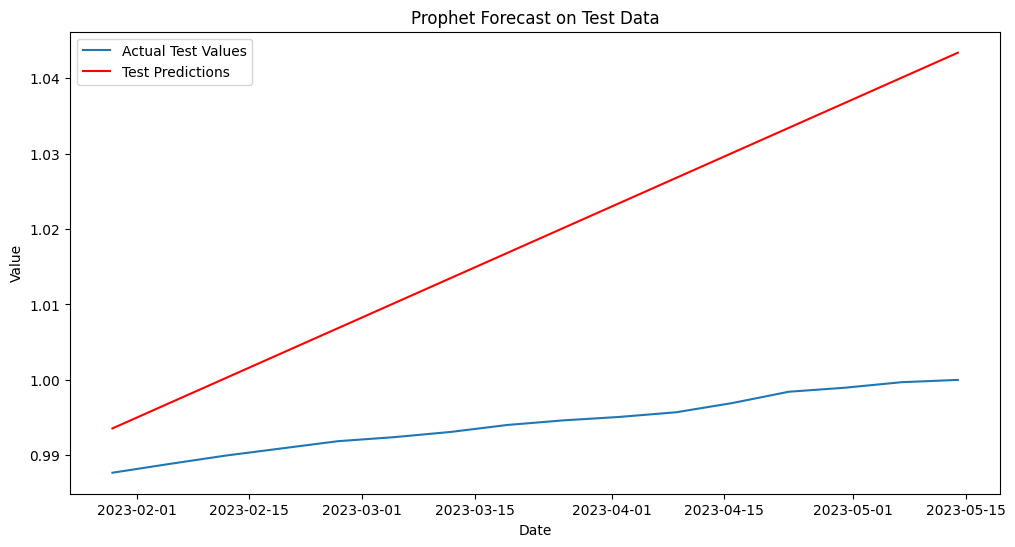

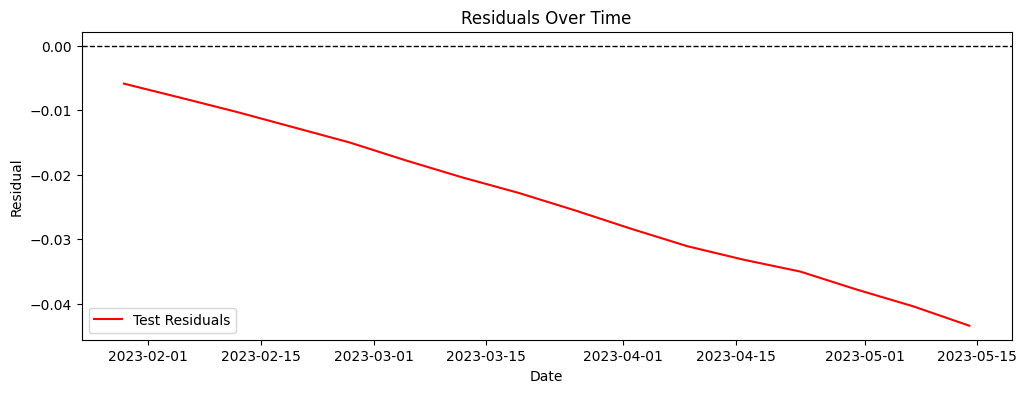

<Figure size 1000x800 with 0 Axes>

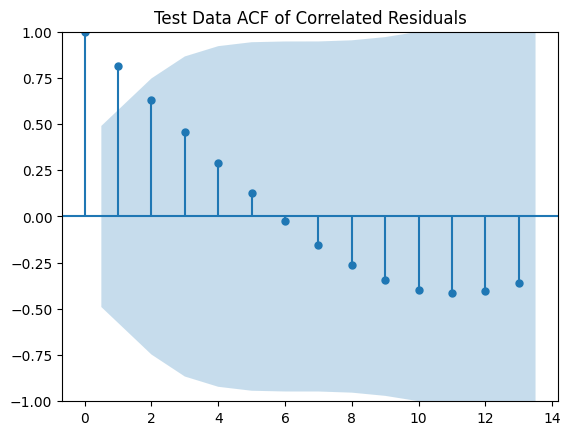

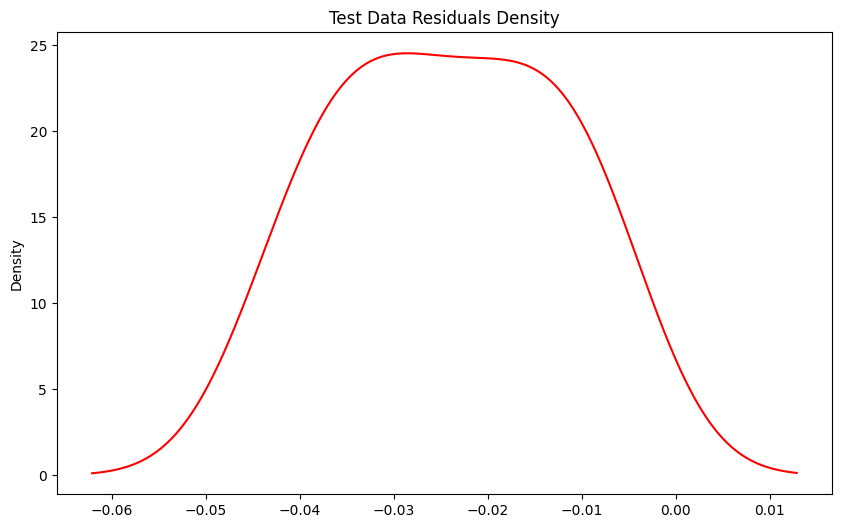

In [ ]:
# Assuming df is your DataFrame with columns 'ds' and 'y'
df_copy = data.copy()
df_copy.columns = ['ds', 'y']

# Split the data into training and test sets
train_size = int(0.8 * len(df_copy))
train_data = df_copy[:train_size]
test_data = df_copy[train_size:]

# Initialize and fit the Prophet model on the training data
final_model = Prophet()
final_model.fit(train_data)

# Make future dataframe for predictions
future = final_model.make_future_dataframe(periods=len(test_data), freq='W')

# Generate predictions for both training and test data
fcst_prophet = final_model.predict(future)

# Filter to only include the forecasted data into predicted_df
filter_train = fcst_prophet['ds'] < test_data['ds'].min()
filter_test = (fcst_prophet['ds'] >= test_data['ds'].min()) & (fcst_prophet['ds'] <= test_data['ds'].max())

predicted_df_train = fcst_prophet[filter_train][['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
predicted_df_test = fcst_prophet[filter_test][['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Merge with actual values for both training and test data
df_copy_train = train_data.copy()
df_copy_train.columns = ['ds', 'ytrue']
df_copy_test = test_data.copy()
df_copy_test.columns = ['ds', 'ytrue']

predicted_df_train = pd.merge(df_copy_train, predicted_df_train, on='ds')
predicted_df_test = pd.merge(df_copy_test, predicted_df_test, on='ds')

# Calculate RMSE for training data
rmse_train = np.sqrt(mean_squared_error(predicted_df_train['ytrue'], predicted_df_train['yhat']))
print(f"Training RMSE: {rmse_train}")

# Calculate RMSE for test data
rmse_test = np.sqrt(mean_squared_error(predicted_df_test['ytrue'], predicted_df_test['yhat']))
print(f"Test RMSE: {rmse_test}")

# Plot the predictions and actual values for both training and test data
plt.figure(figsize=(12, 6))
plt.plot(predicted_df_test.ds, predicted_df_test.ytrue, label='Actual Test Values')
plt.plot(predicted_df_test.ds, predicted_df_test.yhat, label='Test Predictions', color='red')
plt.title('Prophet Forecast on Test Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

# Plot the residuals over time for both training and test data
plt.figure(figsize=(12, 4))
plt.plot(predicted_df_test.ds, predicted_df_test.ytrue - predicted_df_test.yhat, label='Test Residuals', color='red')
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.title('Residuals Over Time')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.legend()
plt.show()

# Plot the residuals ACF for both training and test data
plt.figure(figsize=(10, 8))
acf_test = plot_acf(predicted_df_test.ytrue - predicted_df_test.yhat)
plt.title("Test Data ACF of Correlated Residuals")
plt.show()

# Plot the residual density for both training and test data

predicted_df_test['residuals'] = predicted_df_test.ytrue - predicted_df_test.yhat

plt.figure(figsize=(10, 6))
predicted_df_test.residuals.plot(kind='kde', title='Test Data Residuals Density', color='red')
plt.show()
